# real ETF
512100 for 中证1000 南方
510300 for 沪深300
# 2：30 ETF 收盘价格 done

In [1]:
from empyrical import max_drawdown
from apippy.api import get_price, get_price_minute
import pandas as pd



In [122]:
etf0_data = pd.read_csv('data/512100.csv')
etf1_data = pd.read_csv('data/510300.csv')
# 先dropna
etf0_data.dropna(inplace=True)
etf1_data.dropna(inplace=True)

def share(prev_close, x):
    return (x + prev_close) / prev_close
def etf_share(data, date, amount):
    # 获取date前一天的收盘价
    # print(etf1_data.head(5))
    date_index_location = data.index.get_loc(date)
    if date_index_location == 0:
        # 如果是第一天，直接返回
        return
    previous_date = data.index[date_index_location - 1]
    data.loc[date, 'daily_adjust'] = share(data.loc[previous_date, 'close'], amount/10)
for name in ['etf0', 'etf1']:
    # 重命名列
    data = eval(f'{name}_data')
    
    data.rename(columns={'交易时间': 'date', '开盘价': 'open', '收盘价': 'close',
                         '最高价': 'high', '最低价': 'low', '成交额': 'volume', '成交量': 'total_turnover',
                         '证券代码': 'order_book_id'}, inplace=True)
    data['total_turnover'] = data['total_turnover'].str.replace(',', '').astype(float)
    data['volume'] = data['volume'].str.replace(',', '').astype(float)    
    # 其他列删除
    data.drop(columns=['证券名称', '涨跌', '涨跌幅%'], inplace=True)
    # data.set_index('date', inplace=True)
    data['daily_adjust'] = 1.0






In [113]:
def calculate_metrics(returns):
    """
    Calculates common backtesting metrics.

    Args:
        returns (pd.Series): Series of daily returns.

    Returns:
        dict: Dictionary containing calculated metrics.
    """
    # Ensure returns are not all NaN or zero before calculating metrics
    if returns.isnull().all() or returns.sum() == 0:
         return {
            'Total Return': 0.0,
            'Annualized Return': 0.0,
            'Volatility': 0.0,
            'Sharpe Ratio': 0.0,
            'Max Drawdown': 0.0
         }

    total_return = (1 + returns).prod() - 1 # Correct total return calculation
    # Avoid division by zero or issues with short periods
    if len(returns) == 0:
        annualized_return = 0
    else:
         annualized_return = (1 + total_return) ** (252 / len(returns)) - 1  # Annualize based on actual length

    volatility = returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe = annualized_return / volatility if volatility != 0 else 0 # Sharpe Ratio (assuming 0 risk-free rate)
    max_dd = max_drawdown(returns)  # Maximum Drawdown

    return {
        'Total Return': total_return,
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': max_dd
    }


In [123]:
def preprocessing(etf0_data, etf1_data):
    """
    对数据进行预处理
    :param etf0_data: 中证1000数据
    :param etf1_data: 沪深300数据
    :return: 处理后的数据
    """
    etf0_data = etf0_data.copy()
    etf1_data = etf1_data.copy()
    # 将日期列转换为datetime格式
    etf0_data['date'] = pd.to_datetime(etf0_data['date'])
    etf1_data['date'] = pd.to_datetime(etf1_data['date'])
    
    # 把 order_book_id 列删除
    etf0_data.drop(columns=['order_book_id'], inplace=True)
    etf1_data.drop(columns=['order_book_id'], inplace=True)
    # 将日期列设置为索引
    etf0_data.set_index('date', inplace=True)
    etf1_data.set_index('date', inplace=True)
    etf0_data.loc['2022-09-05', 'daily_adjust'] = 1/0.3656
    # etf0_data.loc['2025-01-15', 'daily_adjust'] = (2.327+0.37/10)/2.327
    etf0_data.loc['2025-01-15', 'daily_adjust'] = share(etf0_data.loc['2025-01-14', 'close'], 0.37/10)

    # etf1
    etf_share(etf1_data, '2024-01-18',  0.69)
    etf_share(etf1_data, '2023-01-16',  0.64)
    etf_share(etf1_data, '2022-01-19',  0.75)
    etf_share(etf1_data, '2021-01-18',  0.72)
    etf_share(etf1_data, '2019-12-11',  0.62)
    etf_share(etf1_data, '2019-01-16',  0.59)
    etf_share(etf1_data, '2018-01-23',  0.46)
    etf_share(etf1_data, '2017-01-23',  0.55)
    etf_share(etf1_data, '2016-01-20',  0.51)
    etf_share(etf1_data, '2015-01-20',  0.35)
    etf_share(etf1_data, '2014-01-21',  0.48)
    etf_share(etf1_data, '2012-12-18',  0.33)

    for name in ['etf0', 'etf1']:
        data = eval(f'{name}_data')
        data['cumulative_adjust'] = data['daily_adjust'].cumprod()
        data['total_turnover'] = data['total_turnover'] * data['cumulative_adjust']
        # 计算收益率
        etf0_data['return'] = etf0_data['close'].pct_change()
        etf1_data['return'] = etf1_data['close'].pct_change()
        
    # rename
    etf0_data.rename(columns=lambda x: f'etf0_{x}' if x != 'date' else x, inplace=True)
    etf1_data.rename(columns=lambda x: f'etf1_{x}' if x != 'date' else x, inplace=True)

    # 合并数据
    # 按照date列进行合并
    merged_data = pd.merge(etf0_data, etf1_data, left_index=True, right_index=True, how='outer')
    # 添加一列return 差值
    merged_data['return_diff'] = merged_data['etf0_return'] - merged_data['etf1_return']
    # 添加一列三日平均
    for window in [3, 5, 10, 20, 40]:
        merged_data[f'return_diff_{window}d_avg'] = merged_data['return_diff'].rolling(window=window).mean()
        merged_data[f'return_diff_{window}d_avg_shifted'] = merged_data[f'return_diff_{window}d_avg'].shift(-window)
    # merged_data['return_diff_3d_avg'] = merged_data['return_diff'].rolling(window=3).mean()
    # merged_data['test'] =  merged_data[f'return_diff_10d_avg'].shift(-20)
    # 添加shift之后的return_diff，return_diff_3d_avg
    merged_data['return_diff_shifted'] = merged_data['return_diff'].shift(-1)
    # merged_data['return_diff_3d_avg_shifted'] = merged_data['return_diff_3d_avg'].shift(-3)
        
    return merged_data
# ori_data = preprocessing(etf0_data, etf1_data)

In [193]:
def add_feature(data):
    """
    添加特征
    :param data: 处理后的数据
    :return: 添加特征后的数据
    """
    data = data.copy()
    # 根据data 的date 创建一个新的dataFrame
    feature = pd.DataFrame(index=data.index)

    # 添加因子：计算过去5天、10天、20天的平均收益率
    for window in [5, 10, 20, 40]:
        feature[f'mean_return_{window}d'] = data['return_diff'].rolling(window=window).mean()
    
    # 计算过去5天、10天、20天的波动率（标准差）
    for window in [5, 10, 20, 40]:
        feature[f'volatility_{window}d'] = data['return_diff'].rolling(window=window).std()

    # 计算过去5天、10天、20天的偏度（skewness）
    for window in [5, 10, 20]:
        feature[f'skew_{window}d'] = data['return_diff'].rolling(window=window).skew()

    for window in [5, 10, 20, 40]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_std_{window}d'] = data[f'{name}_return'].rolling(window=window).std()
    
    # 计算过去5天、10天、20天的最大收益率
    for window in [5, 10, 20, 40]:
        feature[f'max_return_{window}d'] = data['return_diff'].rolling(window=window).max()

    # 计算过去5天、10天、20天的最小收益率
    for window in [5, 10, 20]:
        feature[f'min_return_{window}d'] = data['return_diff'].rolling(window=window).min()
    
    data['etf0_volume_pct'] = data['etf0_volume'].pct_change()
    data['etf1_volume_pct'] = data['etf1_volume'].pct_change()
    for window in [5, 10, 20]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_mean_price_{window}d'] = data[f'{name}_close'].rolling(window=window).mean()
    for name in ['etf0', 'etf1']:
        feature[f'{name}_mean_break'] = feature[f'{name}_mean_price_5d'] - feature[f'{name}_mean_price_20d']
    for window in [5, 10, 20, 40]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_volume_pct_{window}d'] = data[f'{name}_volume_pct'].rolling(window=window).mean()
            # 当日除以window平均
            feature[f'{name}_relative_volume_{window}d'] = data[f'{name}_volume'] / data[f'{name}_volume'].rolling(window=window).mean()
    for window in [5, 10, 20]:
        for name in ['etf0', 'etf1']:
            feature[f'{name}_total_turnover_{window}d'] = data[f'{name}_total_turnover'].rolling(window=window).mean()
    # 因子进行z-score标准化， 用rolling防止泄露
    # 要不要把return_diff 也加到feature里面
    feature['return_diff'] = data['return_diff']
    # feature['return_diff_shifted'] = data['return_diff_shifted']
    # print(data['return_diff_shifted'].head())
    # print(feature['return_diff_shifted'].head())
    # 对feature做异常值处理，明显偏离的值做截断
    for col in feature.columns:
        if col != 'return_diff':
            feature[col] = feature[col].clip(lower=feature[col].expanding().quantile(0.05), upper=feature[col].expanding().quantile(0.95))
    for col in feature.columns:
        if col != 'return_diff':
            feature[col] = (feature[col] - feature[col].rolling(window=30).mean()) / feature[col].rolling(window=30).std()
    return feature
# features = add_feature(ori_data)


In [104]:
# 根据return_diff 做因子筛选
def feature_selection(data, feature, target='return_diff_shifted'):
    """
    特征选择
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :return: 选择的特征
    """
    data = data.copy()
    # 计算相关系数
    corr = feature.corrwith(data[target])
    # print(corr.sort_values(ascending=False))
    # 选择相关系数大于0.05的特征
    selected_features = corr[abs(corr) > 0.05].index.tolist()
    return selected_features
# selected_features = feature_selection(ori_data, features)

# len(selected_features)

In [218]:
# cv
import lightgbm as lgb
from sklearn.model_selection import KFold # Changed from train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit

def train_lgbm_model_cv(data, feature, selected_features, target='return_diff_shifted',
                        start_date='2016-01-01', end_date='2023-12-31',
                        n_splits=5, # Number of CV folds
                        cv_shuffle=True, # Shuffle for KFold
                        cv_random_state=21, # Random state for KFold shuffle
                        # LGBM 参数
                        n_estimators=2000,
                        learning_rate=0.001,
                        max_depth=-1,
                        num_leaves=31,
                        min_child_samples=20,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        reg_alpha=0.1,
                        reg_lambda=0.1,
                        early_stopping_rounds=50,
                        verbose_eval=100 # Controls LGBM's own logging frequency during training
                       ):
    """
    使用交叉验证训练LGBM模型，并返回按性能排序的模型列表和RMSE列表。

    :param data: 处理后的数据 (Pandas DataFrame, 索引为日期时间)
    :param feature: 添加特征后的数据 (Pandas DataFrame, 索引为日期时间)
    :param selected_features: 选择的特征列表
    :param target: 目标变量列名
    :param start_date: 数据开始日期
    :param end_date: 数据结束日期
    :param n_splits: 交叉验证的折数.
    :param cv_shuffle: KFold 是否打乱数据. 对于时间序列，通常建议 False，除非有特定理由.
                     如果为 False，cv_random_state 将无意义.
    :param cv_random_state: KFold 打乱数据时的随机种子.
    :param n_estimators: 树的数量
    :param learning_rate: 学习率
    :param max_depth: 树的最大深度
    :param num_leaves: 每棵树的叶子节点数
    :param min_child_samples: 叶子节点最小样本数
    :param subsample: 数据子采样比例
    :param colsample_bytree: 特征子采样比例
    :param reg_alpha: L1 正则化系数
    :param reg_lambda: L2 正则化系数
    :param early_stopping_rounds: 提前停止的轮数
    :param verbose_eval: 控制LGBM评估日志的频率 (e.g., 100 means print every 100 rounds).
                         -1 or False to disable.
    :return: (model_list, rmse_list) - 模型列表和对应的RMSE列表，按RMSE升序排列 (从好到坏)
    """
    data_df = data.copy()
    feature_df = feature.copy()

    # 确保索引是 DateTimeIndex 类型
    if not isinstance(data_df.index, pd.DatetimeIndex):
        data_df.index = pd.to_datetime(data_df.index)
    if not isinstance(feature_df.index, pd.DatetimeIndex):
        feature_df.index = pd.to_datetime(feature_df.index)

    # 选择数据范围
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    data_df = data_df[(data_df.index >= start_dt) & (data_df.index <= end_dt)]
    feature_df = feature_df[(feature_df.index >= start_dt) & (feature_df.index <= end_dt)]

    # 准备 X 和 y
    X_full = feature_df[selected_features]
    y_full = data_df[target]

    # 合并后删除缺失值，确保 X 和 y 对齐
    temp_df_full = pd.concat([X_full, y_full], axis=1).dropna()
    X = temp_df_full[selected_features]
    y = temp_df_full[target]

    if X.empty or y.empty:
        print("数据为空，请检查日期范围、特征选择或缺失值处理。")
        return [], []

    # 初始化交叉验证器
    # 注意: 对于时间序列数据，TimeSeriesSplit 通常是更好的选择，以避免数据泄露。
    # KFold(shuffle=False) 也可以按顺序划分，但 TimeSeriesSplit 更专门。
    # 如果使用 KFold 且 shuffle=True (如原函数中的 train_test_split)，请确保这符合您的数据特性。
    kf = KFold(n_splits=n_splits, shuffle=cv_shuffle, random_state=cv_random_state if cv_shuffle else None)
    # kf = TimeSeriesSplit(n_splits=n_splits)
    model_list = []
    rmse_list = []

    print(f"开始进行 {n_splits}-折交叉验证...")

    for fold_idx, (train_index, val_index) in enumerate(kf.split(X, y)):
        print(f"\n--- 开始 Fold {fold_idx + 1}/{n_splits} ---")
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # 创建LGBM模型实例
        model = lgb.LGBMRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            num_leaves=num_leaves,
            min_child_samples=min_child_samples,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            reg_alpha=reg_alpha,
            reg_lambda=reg_lambda,
            random_state=cv_random_state + fold_idx if cv_random_state is not None else None, # Vary random state per fold if base is set
            verbose=-1, # Suppress LGBM's own verbose, rely on callbacks and verbose_eval in fit
        )

        # LightGBM Callbacks
        callbacks = []
        if early_stopping_rounds > 0:
            callbacks.append(lgb.early_stopping(
                stopping_rounds=early_stopping_rounds,
                verbose=1 if verbose_eval >=0 else 0 # Print early stopping message if verbose_eval is not silencing all
            ))
        
        # Control fit's verbosity through eval_period for log_evaluation like behavior
        # Note: LGBMRegressor's verbose param is different from verbose in fit/callbacks
        # We will use fit's eval_period for printing evaluation results
        
        print(f"Fold {fold_idx+1}: 开始训练模型，最多 {n_estimators} 轮迭代...")
        
        # tqdm setup for iterations within this fold
        # The actual number of iterations might be less due to early stopping.
        with tqdm(total=n_estimators, desc=f"Fold {fold_idx+1} Training", unit="iter", leave=False) as pbar:
            eval_results_for_pbar = {} # To store latest eval results for pbar

            def tqdm_update_callback(env):
                pbar.update(1)
                # Store results for pbar description
                # env.evaluation_result_list is like: [('Train', 'rmse', 1.23, True), ('Val', 'rmse', 1.56, True)]
                if env.evaluation_result_list:
                    for eval_name_tuple in env.evaluation_result_list:
                        eval_name, metric_name, metric_val, _ = eval_name_tuple
                        if eval_name == 'Val': # We named our validation set 'Val'
                             eval_results_for_pbar[f"{eval_name}_{metric_name}"] = metric_val
                
                desc_parts = [f"Iter: {env.iteration}/{n_estimators}"]
                if 'Val_rmse' in eval_results_for_pbar:
                     desc_parts.append(f"Val RMSE: {eval_results_for_pbar['Val_rmse']:.4f}")
                pbar.set_description(", ".join(desc_parts))
            
            final_callbacks = callbacks + [tqdm_update_callback]

            model.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_names=['Train', 'Val'], # Renamed 'Test' to 'Val' as it's a validation set
                eval_metric='rmse',
                callbacks=final_callbacks,
            
            )
          


        # If early stopping occurred, model is already at best iteration.
        if early_stopping_rounds > 0 and model.best_iteration_ is not None:
            print(f"Fold {fold_idx + 1}: 模型在第 {model.best_iteration_} 轮迭代时达到最佳性能 (提前停止).")
        
        # 预测验证集
        y_pred_val = model.predict(X_val)

        # 计算该折的均方根误差
        fold_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        print(f"Fold {fold_idx + 1} Validation RMSE: {fold_rmse:.4f}")

        model_list.append(model)
        rmse_list.append(fold_rmse)
        pbar.close() # Ensure tqdm pbar for the fold is closed

    print("\n--- 交叉验证全部完成 ---")

    # 按RMSE对模型和RMSE列表进行排序 (从好到坏)
    if rmse_list:
        sorted_indices = np.argsort(rmse_list)
        model_list_sorted = [model_list[i] for i in sorted_indices]
        rmse_list_sorted = [rmse_list[i] for i in sorted_indices]
        
        print("按RMSE排序后的各折结果 (从好到坏):")
        for i, rmse_val in enumerate(rmse_list_sorted):
            # Find original fold index for clarity if needed, though sort order is primary
            original_fold_idx_for_this_rank = sorted_indices[i]
            print(f"  排序 {i+1} (原Fold {original_fold_idx_for_this_rank + 1}): RMSE = {rmse_val:.4f}")
        return model_list_sorted, rmse_list_sorted
    else:
        print("交叉验证未产生任何结果。")
        return [], []


In [302]:
# improved
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # 确保导入 pandas
from tqdm import tqdm

def train_lgbm_model_improved(data, feature, selected_features, target='return_diff_shifted',
                              start_date='2016-01-01', end_date='2023-12-31',
                              test_size=0, random_state=42,
                              # LGBM 参数 - 可以根据需要调整和传入
                              n_estimators=2000, # 增加 n_estimators，配合 early_stopping
                              learning_rate=0.001,
                              max_depth=-1, # 默认 -1 表示没有限制
                              num_leaves=31, # 默认值
                              min_child_samples=20, # 默认值
                              subsample=0.8, # 数据子采样比例
                              colsample_bytree=0.8, # 特征子采样比例
                              reg_alpha=0.1, # L1 正则化
                              reg_lambda=0.1, # L2 正则化
                              early_stopping_rounds=50, # 提前停止的轮数
                              verbose_eval=100 # 每隔多少轮打印评估结果，-1为不打印，0为打印所有
                             ):
    """
    训练LGBM模型（改进版）
    :param data: 处理后的数据 (Pandas DataFrame, 索引为日期时间)
    :param feature: 添加特征后的数据 (Pandas DataFrame, 索引为日期时间)
    :param selected_features: 选择的特征列表
    :param target: 目标变量列名
    :param start_date: 数据开始日期
    :param end_date: 数据结束日期
    :param test_size: 测试集比例
    :param random_state: 随机种子
    :param n_estimators: 树的数量
    :param learning_rate: 学习率
    :param max_depth: 树的最大深度
    :param num_leaves: 每棵树的叶子节点数
    :param min_child_samples: 叶子节点最小样本数
    :param subsample: 数据子采样比例
    :param colsample_bytree: 特征子采样比例
    :param reg_alpha: L1 正则化系数
    :param reg_lambda: L2 正则化系数
    :param early_stopping_rounds: 提前停止的轮数
    :param verbose_eval: 控制LGBM评估日志的频率
    :return: 训练好的模型, RMSE值
    """
    data_df = data.copy()
    feature_df = feature.copy()

    # 确保索引是 DateTimeIndex 类型，如果不是，请先转换
    if not isinstance(data_df.index, pd.DatetimeIndex):
        data_df.index = pd.to_datetime(data_df.index)
    if not isinstance(feature_df.index, pd.DatetimeIndex):
        feature_df.index = pd.to_datetime(feature_df.index)

    # 选择数据范围
    start_dt = pd.to_datetime(start_date)
    end_dt = pd.to_datetime(end_date)

    data_df = data_df[(data_df.index >= start_dt) & (data_df.index <= end_dt)]
    feature_df = feature_df[(feature_df.index >= start_dt) & (feature_df.index <= end_dt)]

    # 划分数据集
    X = feature_df[selected_features]
    y = data_df[target]

    # 删除缺失值 (保持 X 和 y 的索引一致)
    # 先合并再删除，确保对齐
    temp_df = pd.concat([X, y], axis=1).dropna()
    X = temp_df[selected_features]
    y = temp_df[target]

    if X.empty or y.empty:
        print("数据为空，请检查日期范围、特征选择或缺失值处理。")
        return None, float('nan')

    # 划分训练集和测试集
    # 对于时间序列数据，更好的做法是不打乱顺序地划分，或者使用 TimeSeriesSplit
    # 这里仍然使用 train_test_split 作为示例，但可以考虑 shuffle=False
    if test_size > 0:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True) # shuffle=True 是默认行为
    else:
        # 如果不需要测试集，可以直接使用全部数据作为训练集
        X_train, y_train = X, y
        X_test, y_test = None, None
    # 创建LGBM模型实例
    model = lgb.LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_child_samples=min_child_samples,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=random_state,
        verbose=verbose_eval, # -1表示不输出
    )

    # LightGBM Callbacks
    callbacks = []
    if early_stopping_rounds > 0:
        callbacks.append(lgb.early_stopping(stopping_rounds=early_stopping_rounds,
                                            verbose=1)) # verbose=1 会打印early stopping信息
    
    # verbose_eval 控制LightGBM内置的日志输出频率
    # -1: 不输出; 0: 每轮都输出; N: 每N轮输出
    # 我们使用 lgb.log_evaluation() 来替代 fit 中的 verbose 参数，以更好地控制
    if verbose_eval >= 0:
        callbacks.append(lgb.log_evaluation(period=verbose_eval if verbose_eval > 0 else 1))

    
    print(f"开始训练模型，最多 {n_estimators} 轮迭代...")
    with tqdm(total=n_estimators, desc="LGBM Training", unit="iteration") as pbar:
        def tqdm_update_callback(env):
            pbar.update(1)
            # 如果需要，可以在这里添加更多逻辑，比如更新 pbar 的描述
            pbar.set_description(f"Iter: {env.iteration}, Eval RMSE: {env.evaluation_result_list[0][2]:.4f}")

        final_callbacks = callbacks + [tqdm_update_callback]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)] if test_size > 0 else [(X_train, y_train)], # 同时评估训练集和测试集
            eval_names=['Train', 'Val'] if test_size > 0 else ['Train'], # 命名评估集合
            eval_metric='rmse', # 评估指标
            callbacks=final_callbacks
        )

    # tqdm_bar.close() # 如果使用外部的 tqdm_bar

    # 如果发生了提前停止，获取最佳迭代次数
    if early_stopping_rounds > 0 and model.best_iteration_ is not None:
        print(f"模型在第 {model.best_iteration_} 轮迭代时达到最佳性能 (提前停止).")
        # 使用最佳迭代次数的模型进行预测（LGBM fit 后，模型已经是最佳迭代次数状态）
    
    # 预测
    y_pred = model.predict(X_test) if test_size > 0 else model.predict(X_train)

    # 计算均方根误差
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) if test_size > 0 else np.sqrt(mean_squared_error(y_train, y_pred))
    set_name = "Test" if test_size > 0 else "Train"
    print(f'{set_name} RMSE: {rmse:.4f}')

    return model, rmse


# if model:
#     print("模型训练完成。")
#     # 可以查看特征重要性
#     # lgb.plot_importance(model, max_num_features=20)
#     # plt.show()

In [1402]:
# 使用lgb，使用选择的特征来回归return_diff
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm import tqdm

def train_model(data, feature, selected_features, target='return_diff_shifted',
                start_date='2016-01-01', end_date='2023-12-01'):
    """
    训练模型
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :param selected_features: 选择的特征
    :return: 模型
    """
    data = data.copy()
    feature = feature.copy()
    # 选择数据范围
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)

    data = data[(data.index >= start_date) & (data.index <= end_date)]
    feature = feature[(feature.index >= start_date) & (feature.index <= end_date)]
    
    # 划分数据集
    X = feature[selected_features]
    y = data[target]
    
    # 删除缺失值
    X = X.dropna()
    y = y[X.index]
    
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 创建lgb模型
    model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01)
    # 创建 tqdm 进度条
    tqdm_callback = lgb.callback.log_evaluation(period=10)  # 每 10 次迭代打印日志
    tqdm_bar = tqdm(total=model.n_estimators, desc="Training Progress", position=0, leave=True)
    
    def tqdm_callback_wrapper(env):
        tqdm_bar.update(env.iteration - tqdm_bar.n)
    # 训练模型
    model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='rmse',
        callbacks=[tqdm_callback_wrapper]
    )
    tqdm_bar.close()
    # 预测
    y_pred = model.predict(X_test)
    
    # 计算均方根误差
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f'RMSE: {rmse}')
    
    return model
# model = train_model(ori_data, features, selected_features, target = 'return_diff_shifted',)

In [106]:
# new
def signal_generation(data, feature,
                      feature_list, target_list=['return_diff_shifted'], target_weights = None, model_list = None, smooth_list = None):
    """
    信号生成
    :param data: 处理后的数据
    :param feature: 添加特征后的数据
    :param selected_features: 选择的特征
    :return: 加了信号的data
    """
    data = data.copy()
    feature = feature.copy()
    if target_weights is None:
        target_weights = [1] * len(target_list)
    else:
        assert len(target_weights) == len(target_list), "target_weights的长度必须与target_list的长度相同"

    pred = pd.Series(0, index=feature.index)
    for i, model in enumerate(model_list):
        # 预测
        X = feature[feature_list[i]]
        y_pred = model.predict(X)
        if smooth_list[i] is not None:
            # 使用smooth进行平滑
            y_pred = pd.Series(y_pred, index=X.index).rolling(window=smooth_list[i]).mean()
            y_pred = y_pred.fillna(0)
            # # 用ema进行平滑
            # y_pred = pd.Series(y_pred, index=X.index).ewm(span=smooth).mean()
            # y_pred = y_pred.fillna(0)
        # 乘以权重加到pred里
        
        pred += target_weights[i] * y_pred
        # print(pred.head(10))
        # 已经shift过了，所以不需要再shift
    data['signal'] = pred
    # data['signal'] = np.where(data['predicted_return'] > 0, 1, -1)
    
    return data


In [1404]:
# # deprecated signal_generation
# def signal_generation(data, feature, selected_features, target='return_diff_shifted', smooth = None):
#     """
#     信号生成
#     :param data: 处理后的数据
#     :param feature: 添加特征后的数据
#     :param selected_features: 选择的特征
#     :return: 加了信号的data
#     """
#     data = data.copy()
#     feature = feature.copy()
#     # cv
#     model_list, rmse_list = train_lgbm_model_cv(
#         data, features, selected_features,
#         target=target,
#         n_splits=3,
#         n_estimators=3000,
#         learning_rate=0.01,
#         num_leaves=20,
#         max_depth=5,
#         min_child_samples=30,
#         subsample=0.7,
#         colsample_bytree=0.7,
#         reg_alpha=0.15,
#         reg_lambda=0.15,
#         early_stopping_rounds=100,
#         verbose_eval=-1
#     )
#     model = model_list[0]  # 选择第一个模型
#     # improved
#     # model, rmse = train_lgbm_model_improved(
#     #     data, features, selected_features,
#     #     target=target,
#     #     n_estimators=3000,
#     #     learning_rate=0.005,
#     #     num_leaves=20,
#     #     max_depth=5,
#     #     min_child_samples=30,
#     #     subsample=0.7,
#     #     colsample_bytree=0.7,
#     #     reg_alpha=0.1,
#     #     reg_lambda=0.1,
#     #     early_stopping_rounds=100,
#     #     verbose_eval=-1
#     # )
#     # base
#     # model = train_model(data, feature, selected_features, target = target)
#     # 预测
#     X = feature[selected_features]
#     y_pred = model.predict(X)
#     if smooth is not None:
#         # 使用smooth进行平滑
#         y_pred = pd.Series(y_pred, index=X.index).rolling(window=smooth).mean()
#         y_pred = y_pred.fillna(0)
#         # # 用ema进行平滑
#         # y_pred = pd.Series(y_pred, index=X.index).ewm(span=smooth).mean()
#         # y_pred = y_pred.fillna(0)
#     # 将预测结果添加到data中
#     # 已经shift过了，所以不需要再shift
#     data['signal'] = y_pred
#     # data['signal'] = np.where(data['predicted_return'] > 0, 1, -1)
    
#     return data, model


In [107]:
import matplotlib.pyplot as plt
def run_backtest(data, start_date, verbose = 3, end_date = None, thresh = 0, fees = True):
    """
    回测
    :param start_date: 开始日期
    :param end_date: 结束日期
    :param data: 处理后的数据
    :param verbose: 是否打印回测结果
    :return: 回测结果
    """
    # 判断data是否有signal列
    if 'signal' not in data.columns:
        raise ValueError("data must contain 'signal' column")
    data = data.copy()
    
    # 选择数据范围
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date) if end_date else data.index[-1]

    data = data[(data.index >= start_date) & (data.index <= end_date)]
    
    # 好像有点问题
    # data['etf0_daily_return'] = data['etf0_close'] / data['etf0_prev_close'] - 1
    # data['etf1_daily_return'] = data['etf1_close'] / data['etf1_prev_close'] - 1

    data['etf0_daily_return'] = data['etf0_close'].pct_change().fillna(0)
    data['etf1_daily_return'] = data['etf1_close'].pct_change().fillna(0)
    # thresh= 0.0015
    data['shifted_signal'] = data['signal'].shift(1)
    conditions = [
        (data['shifted_signal'] >= thresh),  
        (data['shifted_signal'] < thresh), 
    ]
    choices = [
        data['etf0_daily_return'],  # 买入中证1000
        data['etf1_daily_return'],   # 买入沪深300
    ]
    
    data['strategy_daily_return'] = np.select(conditions, choices, default=0)

    data['signal_change'] = ((data['signal']-thresh) * ((data['signal']-thresh).shift(1)) < 0).astype(int)
    if fees:
        data['strategy_daily_return'] = (1 + data['strategy_daily_return'])* np.where(data['signal_change'] == 1, (1 - 0.001)**2, 1) - 1
    data['strategy_cumulative'] = (1 + data['strategy_daily_return']).cumprod() - 1

    data['benchmark_daily_return'] = data['etf0_close'].pct_change().fillna(0)
    data['benchmark_cumulative'] = (1 + data['benchmark_daily_return']).cumprod() - 1
    data['etf1_daily_return'] = data['etf1_close'].pct_change().fillna(0)
    data['etf1_cumulative'] = (1 + data['etf1_daily_return']).cumprod() - 1
    data['profit_daily'] = data['strategy_daily_return'] - data['benchmark_daily_return']
    data['profit_cumulative'] = (1 + data['profit_daily']).cumprod() - 1
    if verbose >= 2:
        plt.figure(figsize=(12, 6))

        # Plot strategy cumulative return
        plt.plot(data.index, data['strategy_cumulative'], label='Strategy')
        plt.plot(data.index, data['profit_cumulative'], label='Profit (Strategy - Benchmark)', linestyle='--')
        if verbose >= 3:
        # Highlight different positions with colors
        # signale 是1绿色买中证1000，signal是-1 红色买沪深300
            for i in range(len(data) - 1):
                # if data['shifted_signal'].iloc[i] == 0:
                #     plt.axvspan(data.index[i], data.index[i + 1], color='gray', alpha=0.2, label='Cash Position' if i == 0 else None)
                if data['signal'].iloc[i] >= thresh:
                    plt.axvspan(data.index[i], data.index[i + 1], color='green', alpha=0.2)
                elif data['signal'].iloc[i] < thresh:
                    plt.axvspan(data.index[i], data.index[i + 1], color='red', alpha=0.2)

        # Plot benchmark cumulative return
        plt.plot(data.index, data['benchmark_cumulative'], label='Benchmark (Buy & Hold ETF0)')
        
        plt.plot(data.index, data['etf1_cumulative'], label='Profit (Buy & Hold ETF1)')
        
        plt.legend()
        plt.title('Strategy vs Benchmark Cumulative Return')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.grid(True)
        plt.show()
    strategy_metrics = calculate_metrics(data['strategy_daily_return'])
    benchmark_metrics = calculate_metrics(data['benchmark_daily_return']) # Use the pct_change series for benchmark metrics
    if verbose >= 1:
        print("\n--- Strategy Metrics ---")
        for metric, value in strategy_metrics.items():
            print(f"{metric}: {value:.4f}")

        print("\n--- Benchmark Metrics (Buy & Hold ETF0) ---")
        for metric, value in benchmark_metrics.items():
            print(f"{metric}: {value:.4f}")


    return data, strategy_metrics, benchmark_metrics

In [124]:
ori_data = preprocessing(etf0_data, etf1_data)
features = add_feature(ori_data)

/tmp/ipykernel_1709675/3047773531.py:35: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['etf0_volume_pct'] = data['etf0_volume'].pct_change()


In [315]:
# target = 'return_diff_10d_avg_shifted'
target_list = ['return_diff_3d_avg_shifted', 'return_diff_5d_avg_shifted',
                'return_diff_10d_avg_shifted', 'return_diff_20d_avg_shifted']
train_start_date = '2017-01-01'
train_end_date = '2024-12-01'
# selected_features = feature_selection(ori_data, features)
model_list = []
feature_list = []
default_config = {
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'num_leaves': 20,
    'max_depth': 5,
    'min_child_samples': 30,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'early_stopping_rounds': 100,
    'verbose_eval': -1,
    'start_date': train_start_date,
    'end_date': train_end_date,
    'data': ori_data,
    'feature': features,
    'selected_features': None
}
config_list = [default_config.copy() for _ in range(len(target_list))]
config_list[0]['reg_alpha'] = 0.15
config_list[0]['reg_lambda'] = 0.15
config_list[1]['reg_alpha'] = 0.15
config_list[1]['reg_lambda'] = 0.15

for i,target in enumerate(target_list):
    selected_features = feature_selection(ori_data, features, target=target)
    config_list[i]['selected_features'] = selected_features
    config_list[i]['target'] = target
    # tmp_model_list, rmse = train_lgbm_model_cv(
    #     **config_list[i]  # 使用解包操作符传递参数
    # )
    # model_list.append(tmp_model_list[0])  # 选择第一个模型
    model, rmse = train_lgbm_model_improved(
        **config_list[i]  # 使用解包操作符传递参数
    )
    model_list.append(model)
    feature_list.append(selected_features)
# selected_features = features.columns.tolist()



开始训练模型，最多 2000 轮迭代...


Iter: 0, Eval RMSE: 0.0060:   0%|          | 1/2000 [00:00<00:15, 130.31iteration/s]

Iter: 52, Eval RMSE: 0.0058:   3%|▎         | 53/2000 [00:00<00:07, 265.32iteration/s]

Training until validation scores don't improve for 100 rounds


Iter: 1999, Eval RMSE: 0.0050: 100%|██████████| 2000/2000 [00:02<00:00, 692.92iteration/s] 


模型在第 0 轮迭代时达到最佳性能 (提前停止).
Train RMSE: 0.0050
开始训练模型，最多 2000 轮迭代...


Iter: 48, Eval RMSE: 0.0044:   2%|▏         | 49/2000 [00:00<00:07, 272.48iteration/s]

Training until validation scores don't improve for 100 rounds


Iter: 1999, Eval RMSE: 0.0038: 100%|██████████| 2000/2000 [00:02<00:00, 685.69iteration/s] 


模型在第 0 轮迭代时达到最佳性能 (提前停止).
Train RMSE: 0.0038
开始训练模型，最多 2000 轮迭代...


Iter: 50, Eval RMSE: 0.0029:   3%|▎         | 51/2000 [00:00<00:06, 279.49iteration/s]

Training until validation scores don't improve for 100 rounds


Iter: 1999, Eval RMSE: 0.0023: 100%|██████████| 2000/2000 [00:02<00:00, 713.24iteration/s] 


模型在第 0 轮迭代时达到最佳性能 (提前停止).
Train RMSE: 0.0023
开始训练模型，最多 2000 轮迭代...


Iter: 55, Eval RMSE: 0.0022:   3%|▎         | 56/2000 [00:00<00:06, 296.08iteration/s]

Training until validation scores don't improve for 100 rounds


Iter: 1999, Eval RMSE: 0.0018: 100%|██████████| 2000/2000 [00:02<00:00, 689.36iteration/s] 


模型在第 0 轮迭代时达到最佳性能 (提前停止).
Train RMSE: 0.0018


In [316]:
target_weights = [ 0.3, 0.2, 1, 0.5]
smooth_list = [1, 3, 5, 5]
signaled_data = signal_generation(ori_data, features, 
                                  feature_list=feature_list, model_list= model_list, target_list=target_list, target_weights = target_weights, smooth_list = smooth_list)

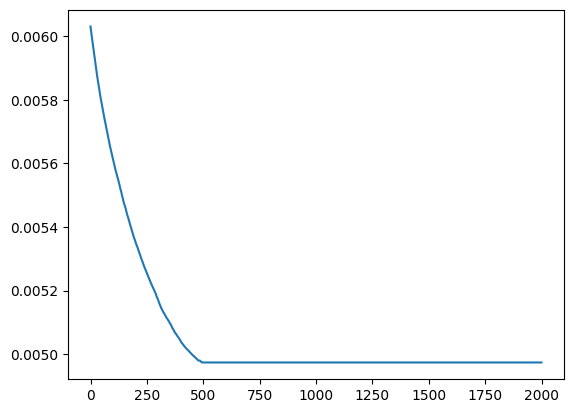

In [317]:

plt.plot(model_list[0].evals_result_['Train']['rmse'], label='Train RMSE')
# plt.plot(model_list[0].evals_result_['Val']['rmse'], label='Test RMSE')

/tmp/ipykernel_1709675/2040841013.py:26: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['etf0_daily_return'] = data['etf0_close'].pct_change().fillna(0)
/tmp/ipykernel_1709675/2040841013.py:46: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data['benchmark_daily_return'] = data['etf0_close'].pct_change().fillna(0)


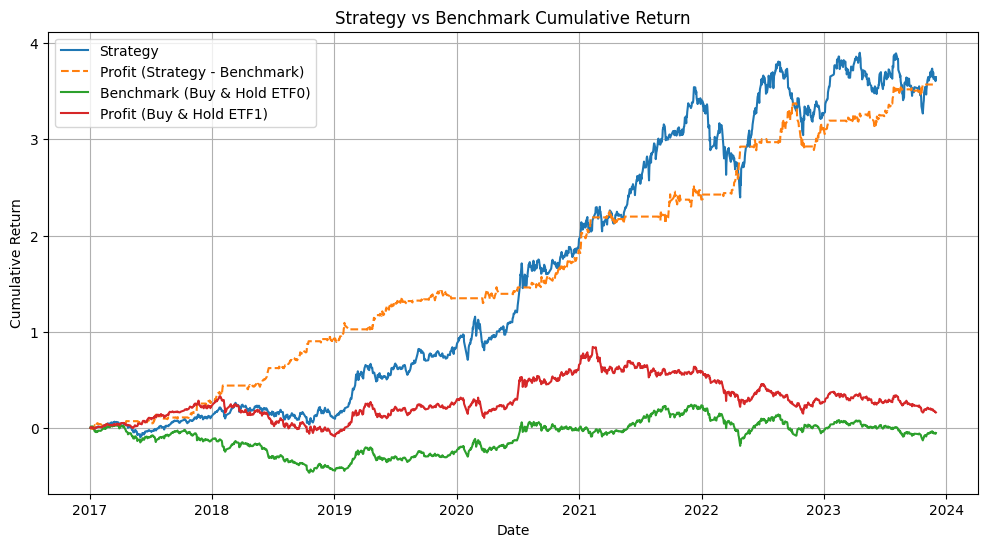


--- Strategy Metrics ---
Total Return: 3.6473
Annualized Return: 0.2590
Volatility: 0.2067
Sharpe Ratio: 1.2527
Max Drawdown: -0.2523

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: -0.0526
Annualized Return: -0.0081
Volatility: 0.2290
Sharpe Ratio: -0.0352
Max Drawdown: -0.4828


In [318]:
# 训练集
train_set_result, _ ,_ = run_backtest(
    data = signaled_data,
    start_date = '2017-01-01',
    end_date = '2023-12-01',
    verbose = 2,
    # fees= False
)

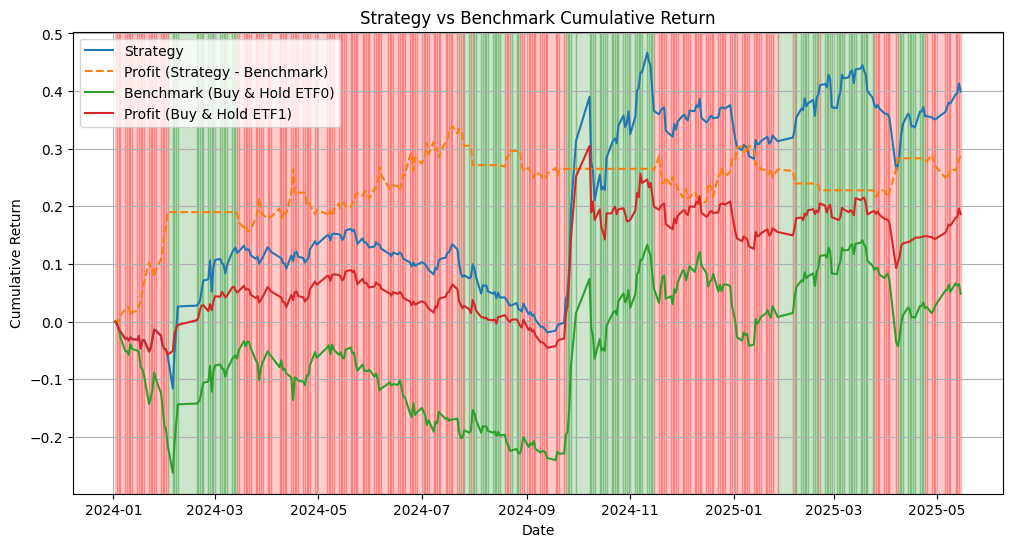


--- Strategy Metrics ---
Total Return: 0.3991
Annualized Return: 0.2944
Volatility: 0.2634
Sharpe Ratio: 1.1176
Max Drawdown: -0.1546

--- Benchmark Metrics (Buy & Hold ETF0) ---
Total Return: 0.0483
Annualized Return: 0.0369
Volatility: 0.3219
Sharpe Ratio: 0.1147
Max Drawdown: -0.2620


In [319]:
backtest_results, strat_metrics, bench_metrics = run_backtest(
    data = signaled_data,
    start_date='2024-01-01',
    # end_date='2024-03-01',
    verbose = 3,
    # fees = False
)

In [1761]:
# 看看有多少signal是正的
(train_set_result['signal']<0).sum()

1364

In [1758]:
train_set_result['signal_change'].sum()

84

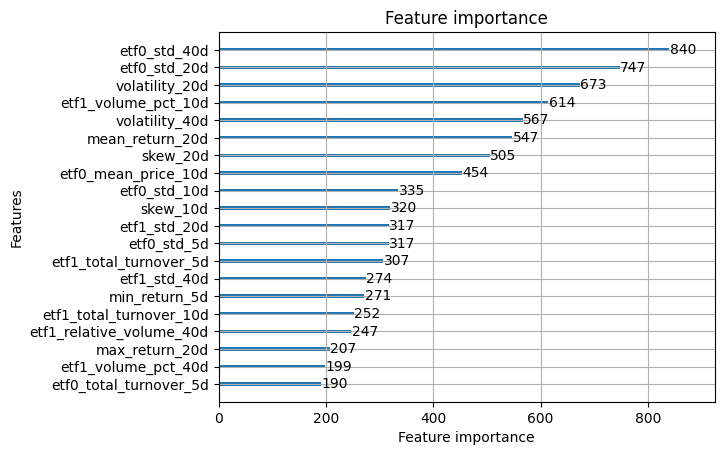

In [1300]:

# 可以查看特征重要性
lgb.plot_importance(output_model, max_num_features=20)
plt.show()